In [24]:
import torch
import numpy as np
import scipy.stats as stats
from scipy.stats import multivariate_normal, norm, bernoulli
import matplotlib.pyplot as plt

In [40]:
from gibbsibp import UncollapsedGibbsIBP, normalise_bern_logpostprop

In [61]:
F_np = np.array(
    [[0.51, -0.01],
     [0.49, 0.01],
     [0.01, 0.5]]
    )
X_np = np.array(
    [[0.0, 1.0],
     [0.0, 1.0],
     [1.0, 0.0]]
    )

A_np = np.array(
    [[0.4, 0.1],
     [0.1, 0.4]]
    )
Y_np = np.array(
    [[0.0, 1.0],
     [1.0, 0.0]]
    )
Z_np = np.array(
    [[1.0, 0.0],
     [1.0, 0.0],
     [0.0, 1.0]]
    )

SIGMA2_N = 0.05
SIGMA2_A = 1.0
LAMBD = 0.75
EPSILON = 0.25
N=3
K=2
D=2
T=2

F = torch.tensor(F_np, dtype=torch.float32)
X = torch.tensor(X_np, dtype=torch.float32)
A = torch.tensor(A_np, dtype=torch.float32)
Y = torch.tensor(Y_np, dtype=torch.float32)
Z = torch.tensor(Z_np, dtype=torch.float32)

inf = UncollapsedGibbsIBP(K=1, max_K=6, alpha=0.01, sigma2_a=SIGMA2_A, phi=0.25, sigma2_n=SIGMA2_N, epsilon=EPSILON, lambd=LAMBD)

As, Zs, Ys = inf.gibbs(F, X, 0)

### Test of Gaussian log-likelihood $P(F|A,Z)$
Tests the method `loglik_f_i__given_Az`, and also `loglik_f_i__given_Az_Knew` with `k_new=0`

In [ ]:
# Calculate log likelihood using loglik_f_i__given_Az
for i in range(F.shape[0]):

    my_loglik = inf.loglik_f_i__given_Az(F[i:i+1,:], A, Z[i:i+1,:]).numpy()[0]

    # Compare results with the log likelihood calculated in scipy
    mean = (Z[i:i+1]@A).numpy()[0]
    cov = np.eye(2)*SIGMA2_N
    multivariate_normal.logpdf(A_np, mean=mean, cov=cov)

    sp_loglik = multivariate_normal.logpdf(F_np[i,:], mean, cov)

    if np.isclose(my_loglik, sp_loglik, atol=1e-6):
        print(f"Test passed for sample {i}")

# Calculate log likelihood using loglik_f_i__given_Az_Knew
for i in range(F.shape[0]):

    my_loglik = inf.loglik_f_i__given_Az_Knew(F[i:i+1,:], A, Z[i:i+1,:], k_new=0).numpy()[0]

    # Compare results with the log likelihood calculated in scipy
    mean = (Z[i:i+1]@A).numpy()[0]
    cov = np.eye(2)*SIGMA2_N
    multivariate_normal.logpdf(A_np, mean=mean, cov=cov)

    sp_loglik = multivariate_normal.logpdf(F_np[i,:], mean, cov)

    if np.isclose(my_loglik, sp_loglik, atol=1e-6):
        print(f"Test passed for sample {i}")

Test passed for sample 0
Test passed for sample 1
Test passed for sample 2
Test passed for sample 0
Test passed for sample 1
Test passed for sample 2


### PIT test for Gaussian posterior $P(A|F,Z)$
Tests the method `resample_A`

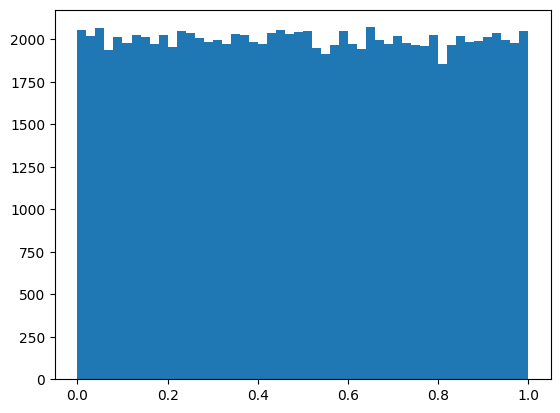

KstestResult(statistic=np.float64(0.0033357054183743573), pvalue=np.float64(0.21530142982209854), statistic_location=np.float64(0.5210842945816256), statistic_sign=np.int8(1))


In [ ]:
SIGMA2_N = 0.2
SIGMA2_A = 0.4
inf = UncollapsedGibbsIBP(K=3, max_K=6, alpha=0.01, sigma2_a=SIGMA2_A, phi=0.25, sigma2_n=SIGMA2_N, epsilon=0.25, lambd=0.75)

res = []
for i in range(100000):
    # Sample from the prior
    A_true = inf.sample_A_prior(K, D)
    # Sample from the likelihood
    f_means = Z @ A_true
    f_cov = SIGMA2_N*np.eye(D)
    F_obs = torch.zeros(N,D)
    for i in range(N):
        F_obs[i] = torch.tensor(multivariate_normal.rvs(mean=f_means[i], cov=f_cov))

    # Calculate parameters of the posterior
    temp = ((Z.T @ Z) + ((SIGMA2_N/SIGMA2_A)*torch.eye(K))).inverse()
    post_mu = temp @ Z.T @ F_obs
    post_cov = SIGMA2_N*temp
    # Isolate one element
    mean = post_mu.numpy()[0,0]
    var = post_cov.numpy()[0,0]
    
    # perform PIT by evaluating the CDF of the posterior at true value of the parameter
    res.append(norm.cdf(A_true.numpy()[0,0], mean, np.sqrt(var)))

res = np.array(res)
plt.hist(res, bins=50)
plt.show()
print(stats.kstest(res, 'uniform'))

### Test of bernoulli likelihood $P(X|Y,Z)$

In [38]:
# Calculate log likelihood using loglik_x__t_given_Zy
for k in range(X.shape[1]):

    my_loglik = inf.loglik_x__t_given_Zy(X[:,k:k+1], Z, Y[:,k:k+1]).numpy()

    # Calculate the probability of observing 1
    n_actfeat = torch.matmul(Z, Y[:,k:k+1])
    p = 1 - ((((1 - LAMBD)**n_actfeat))*(1 - EPSILON)) # probability of observing 1
    
    sp_loglik = 0
    for i in range(X.shape[0]):
        sp_loglik += bernoulli.logpmf(X_np[i,k], p[i,0])

    # Compare results with the log likelihood calculated in scipy
    if np.isclose(my_loglik, sp_loglik, atol=1e-6):
        print(f"Test passed for sample {k}")

Test passed for sample 0
Test passed for sample 1


### RPIT Test of bernoulli posterior $P(Y|X,Z)$

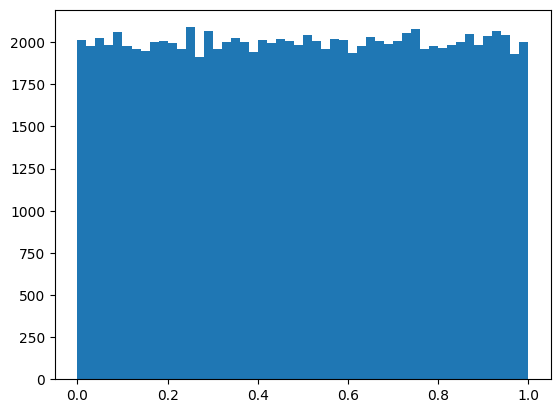

KstestResult(statistic=np.float64(0.0016246740341187005), pvalue=np.float64(0.9540602511072882), statistic_location=np.float32(0.6411747), statistic_sign=np.int8(-1))


In [375]:
LAMBD = 0.8
EPSILON = 0.2
PHI = 0.25
inf = UncollapsedGibbsIBP(K=2, max_K=6, alpha=0.01, sigma2_a=SIGMA2_A, phi=PHI, sigma2_n=SIGMA2_N, epsilon=EPSILON, lambd=LAMBD)
As, Zs, Ys = inf.gibbs(F, X, 0)

res = []
for i in range(100000):
    # Sample from the prior
    Y_true = inf.sample_Y_prior(K, T)
    #print(Y_true)
    # Sample from the likelihood
    X_actfeat = Z @ Y_true # number of active features at the specific pixel within a given observation    
    #print(X_actfeat)
    X_obs = torch.zeros(N,T)
    for i in range(N):
        for j in range(T):
            p = 1 - (((1 - LAMBD)**X_actfeat[i,j])*(1 - EPSILON))
            X_obs[i,j] = torch.tensor(bernoulli.rvs(p))
    #print(X_obs)

    # Calculate parameters of the posterior
    pYkt_1_arr = torch.zeros(K, T)

    log_prior_Y_kt_0 = torch.log(1 - torch.tensor(PHI))
    log_prior_Y_kt_1 = torch.log(torch.tensor(PHI))
    Y_curr = inf.sample_Y_prior(K, T)
    
    #print(Y_curr)

    for r in range(1):
        for k in range(K):
            for t in range(T):
                # Calculate log posterior proportionals for Y_kt = 0 and Y_kt = 1
                Y_curr[k, t] = 0
                logp_Ykt_0 = log_prior_Y_kt_0 + inf.loglik_x__t_given_Zy(X_obs[:, t:t+1], Z, Y_curr[:, t:t+1])
                Y_curr[k, t] = 1
                logp_Ykt_1 = log_prior_Y_kt_1 + inf.loglik_x__t_given_Zy(X_obs[:, t:t+1], Z, Y_curr[:, t:t+1])
                # Normalise to get the probabilities
                pYkt_0, pYkt_1 = normalise_bern_logpostprop(logp_Ykt_0, logp_Ykt_1)
                #Y_curr[k, t] = torch.distributions.Bernoulli(probs=pYkt_1).sample()
                pYkt_1_arr[k, t] = pYkt_1
    
    #print(Y_curr)
    #print(pYkt_1_arr)

    #print(Z@pYkt_1_arr)

    # perform !!Randomised!! PIT
    u = stats.uniform.rvs()
    if Y_true[0,0] == 0:
        u = u * (1 - pYkt_1_arr[0,0])
    else:
        u = (1-pYkt_1_arr[0,0]) + u*pYkt_1_arr[0,0]
    res.append(u)

res = np.array(res)
#print(res)
plt.hist(res, bins=50)
plt.show()
print(stats.kstest(res, 'uniform'))